## Training a Neural Network with Python
<br><br>

### Introduction

<img width="60%" class="imgright" src="../images/neural_networks_learning.webp" srcset="../images/neural_networks_learning_800w.webp 800w,../images/neural_networks_learning_700w.webp 700w,../images/neural_networks_learning_600w.webp 600w,../images/neural_networks_learning_500w.webp 500w,../images/neural_networks_learning_400w.webp 400w,../images/neural_networks_learning_350w.webp 350w,../images/neural_networks_learning_300w.webp 300w" alt="Teacher explaining neural network" />

In the chapter "[Running Neural Networks](running_neural_networks.php)", we programmed a class in Python code called 'NeuralNetwork'. The instances of this class are networks with three layers. When we instantiate an ANN of this class, the weight matrices between the layers are automatically and randomly chosen. It is even possible to run such a ANN on some input, but naturally it doesn't make a lot of sense exept for testing purposes. Such an ANN cannot provide correct classification results. In fact, the classification results are in no way adapted to the expected results. The values of the weight matrices have to be set according the the classification task. We need to improve the weight values, which means that we have to train our network. To train it we have to implement backpropagation in the ```train``` method. If you don't understand backpropagation and want to understand it, we recommend to go back to the chapter [Backpropagation in Neural Networks](neural_networks_backpropagation.php).

After knowing und hopefully understanding backpropagation, you are ready to fully understand the ```train``` method. 

<br>



The ```train``` method is called with an input vector and a target vector. The shape of the vectors can be one-dimensional, but they will be automatically turned into the correct  two-dimensional shape, i.e. ```reshape(input_vector.size, 1)``` and ```reshape(target_vector.size, 1)```. After this we call the ```run``` method to get the result of the network ```output_vector_network = self.run(input_vector)```.  This output may differ from the ```target_vector```. We calculate the ```output_error``` by subtracting the output of the network ```output_vector_network``` from the ```target_vector```. 

In [1]:
%%capture
%%writefile neural_networks1.py
import numpy as np
from scipy.special import expit as activation_function
from scipy.stats import truncnorm

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

class NeuralNetwork:
    
    def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate 
        self.create_weight_matrices()
        
    def create_weight_matrices(self):
        """ A method to initialize the weight matrices of the neural network"""
        rad = 1 / np.sqrt(self.no_of_in_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.weights_in_hidden = X.rvs((self.no_of_hidden_nodes, 
                                       self.no_of_in_nodes))
        rad = 1 / np.sqrt(self.no_of_hidden_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.weights_hidden_out = X.rvs((self.no_of_out_nodes, 
                                        self.no_of_hidden_nodes))
        
    
    def train(self, input_vector, target_vector):
        """
        input_vector and target_vector can be tuples, lists or ndarrays
        """
        # make sure that the vectors have the right shape
        input_vector = np.array(input_vector)
        input_vector = input_vector.reshape(input_vector.size, 1)
        target_vector = np.array(target_vector).reshape(target_vector.size, 1)

        output_vector_hidden = activation_function(self.weights_in_hidden @ input_vector)
        output_vector_network = activation_function(self.weights_hidden_out @ output_vector_hidden)
        
        output_error = target_vector - output_vector_network
        tmp = output_error * output_vector_network * (1.0 - output_vector_network)    
        self.weights_hidden_out += self.learning_rate  * (tmp @ output_vector_hidden.T)

        # calculate hidden errors:
        hidden_errors = self.weights_hidden_out.T @ output_error
        # update the weights:
        tmp = hidden_errors * output_vector_hidden * (1.0 - output_vector_hidden)
        self.weights_in_hidden += self.learning_rate * (tmp @ input_vector.T)  
    
    def run(self, input_vector):
        """
        running the network with an input vector 'input_vector'. 
        'input_vector' can be tuple, list or ndarray
        """
        # make sure that input_vector is a column vector:
        input_vector = np.array(input_vector)
        input_vector = input_vector.reshape(input_vector.size, 1)
        input4hidden = activation_function(self.weights_in_hidden @ input_vector)
        output_vector_network = activation_function(self.weights_hidden_out @ input4hidden)
        return output_vector_network
            
    def evaluate(self, data, labels):
        """
        Counts how often the actual result corresponds to the
        target result. 
        A result is considered to be correct, if the index of
        the maximal value corresponds to the index with the "1"
        in the one-hot representation,
        e.g.
        res = [0.1, 0.132, 0.875]
        labels[i] = [0, 0, 1]
        """
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i].argmax():
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs

We assume that you save the previous code in a file called ```neural_networks1.py```. We will use it under this name in the coming examples.

To test this neural network class we need train and test data. We create the data with ```make_blobs``` from ```sklearn.datasets```.

In [2]:
from sklearn.datasets import make_blobs

n_samples = 500
blob_centers = ([2, 6], [6, 2], [7, 7])
n_classes = len(blob_centers)
data, labels = make_blobs(n_samples=n_samples, 
                          centers=blob_centers, 
                          random_state=7)

Let us visualize the previously created data:

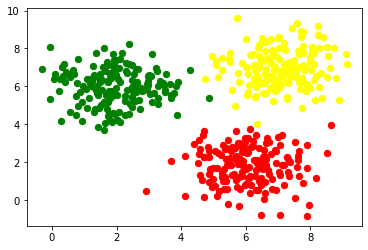

In [3]:
import matplotlib.pyplot as plt

colours = ('green', 'red', "yellow")
fig, ax = plt.subplots()

for n_class in range(n_classes):
    ax.scatter(data[labels==n_class][:, 0], 
               data[labels==n_class][:, 1], 
               c=colours[n_class], 
               s=40, 
               label=str(n_class))

The labels are wrongly represented. They are in a one-dimensional vector: 

In [4]:
labels[:7]

array([2, 2, 1, 0, 2, 0, 1])

We need a one-hot representation for each label. So the labels are represented as

| Label | One-Hot Representation |
|-------|------------------------|
| 0     | (1, 0, 0)              |
| 1     | (0, 1, 0)              |
| 2     | (0, 0, 1)              |

We can easily change the labels with the following commands:

In [5]:
import numpy as np

labels = np.arange(n_classes) == labels.reshape(labels.size, 1)
labels = labels.astype(np.float)
labels[:7]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

We are ready now to create a train and a test data set:

In [6]:
from sklearn.model_selection import train_test_split

res = train_test_split(data, labels, 
                       train_size=0.8,
                       test_size=0.2,
                       random_state=42)
train_data, test_data, train_labels, test_labels = res    
train_labels[:10]

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

We create a neural network with two input nodes, and three output nodes. One output node for each class:

In [7]:
from neural_networks1 import NeuralNetwork

simple_network = NeuralNetwork(no_of_in_nodes=2, 
                               no_of_out_nodes=3, 
                               no_of_hidden_nodes=5,
                               learning_rate=0.3)

The next step consists in training our network with the ```data``` and ```labels``` from our training samples:

In [8]:
for i in range(len(train_data)):
    simple_network.train(train_data[i], train_labels[i])

We now have to check how well our network has learned. For this purpose, we will use the evaluate function:

In [9]:
simple_network.evaluate(train_data, train_labels)

(390, 10)

### Neural Network with Bias Nodes

We already introduced the basic idea and necessity of bias nodes in the chapter ["Simple Neural Network"](simple_neural_network.php), in which we focussed on very simple linearly separable data sets. We learned that a bias node is a node that is always returning the same output. In other words: It is a node which is not depending on some input and it does not have any input. The value of a bias node is often set to one, but it can be set to other values as well. Except for zero, which makes no sense for obvious reasons. If a neural network does not have a bias node in a given layer, it will not be able to produce output in the next layer that differs from 0 when the feature values are 0. Generally speaking, we can say that bias nodes are used to increase the flexibility of the network to fit the data. Usually, there will be not more than one bias node per layer. The only exception is the output layer, because it makes no sense to add a bias node to this layer.

The following diagram shows the first two layers of our previously used three-layered neural network:


<img width="80%" src="../images/weights_input2hidden_bias.webp" srcset="../images/weights_input2hidden_bias_800w.webp 800w,../images/weights_input2hidden_bias_700w.webp 700w,../images/weights_input2hidden_bias_600w.webp 600w,../images/weights_input2hidden_bias_500w.webp 500w,../images/weights_input2hidden_bias_400w.webp 400w,../images/weights_input2hidden_bias_350w.webp 350w,../images/weights_input2hidden_bias_300w.webp 300w" alt="Weights Array from input to hidden layer with bias" />

We can see from this diagram that our weight matrix needs one additional column and the bias value has to be added to the input vector:

![Weights Array from hidden to output layer with bias, matrix multiplication](../images/weight_input_matrix_multiplication_bias.webp "Weights Array from hidden to output layer with Bias Matrix Multiplication")

Again, the situation for the weight matrix between the hidden and the output layer is similar:

<img width="95%" src="../images/weights_hidden2output_bias.webp" srcset="../images/weights_hidden2output_bias_800w.webp 800w,../images/weights_hidden2output_bias_700w.webp 700w,../images/weights_hidden2output_bias_600w.webp 600w,../images/weights_hidden2output_bias_500w.webp 500w,../images/weights_hidden2output_bias_400w.webp 400w,../images/weights_hidden2output_bias_350w.webp 350w,../images/weights_hidden2output_bias_300w.webp 300w" alt="Weights Array from hidden  to output layer with bias" />

The same is true for the corresponding matrix:

![Weights Array from hidden to output layer with bias, matrix multiplication](../images/weight_hidden_matrix_multiplication_bias.webp "Weights Array from hidden to output layer with Bias Matrix Multiplication")

The following is a complete Python class implementing our network with bias nodes:

In [10]:
%%capture
%%writefile neural_networks2.py

import numpy as np
from scipy.stats import truncnorm
from scipy.special import expit as activation_function

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

class NeuralNetwork:
            
    def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate,
                 bias=None):  
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.learning_rate = learning_rate 
        self.bias = bias
        self.create_weight_matrices()
    
        
    def create_weight_matrices(self):
        """ A method to initialize the weight matrices of the neural 
        network with optional bias nodes"""   
        bias_node = 1 if self.bias else 0 
        rad = 1 / np.sqrt(self.no_of_in_nodes + bias_node)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.weights_in_hidden = X.rvs((self.no_of_hidden_nodes, 
                                        self.no_of_in_nodes + bias_node))
        rad = 1 / np.sqrt(self.no_of_hidden_nodes + bias_node)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.weights_hidden_out = X.rvs((self.no_of_out_nodes, 
                                         self.no_of_hidden_nodes + bias_node))

        
    def train(self, input_vector, target_vector):
        """ input_vector and target_vector can be tuple, list or ndarray """

        # make sure that the vectors have the right shap
        input_vector = np.array(input_vector)
        input_vector = input_vector.reshape(input_vector.size, 1)        
        if self.bias:
            # adding bias node to the end of the input_vector
            input_vector = np.concatenate( (input_vector, [[self.bias]]) )
        target_vector = np.array(target_vector).reshape(target_vector.size, 1)

        output_vector_hidden = activation_function(self.weights_in_hidden @ input_vector)
        if self.bias:
            output_vector_hidden = np.concatenate( (output_vector_hidden, [[self.bias]]) ) 
        output_vector_network = activation_function(self.weights_hidden_out @ output_vector_hidden)
        
        output_error = target_vector - output_vector_network  
        # update the weights:
        tmp = output_error * output_vector_network * (1.0 - output_vector_network)     
        self.weights_hidden_out += self.learning_rate  * (tmp @ output_vector_hidden.T)

        # calculate hidden errors:
        hidden_errors = self.weights_hidden_out.T @ output_error
        # update the weights:
        tmp = hidden_errors * output_vector_hidden * (1.0 - output_vector_hidden)
        if self.bias:
            x = (tmp @input_vector.T)[:-1,:]     # last row cut off,
        else:
            x = tmp @ input_vector.T
        self.weights_in_hidden += self.learning_rate *  x


           
    def run(self, input_vector):
        """
        running the network with an input vector 'input_vector'. 
        'input_vector' can be tuple, list or ndarray
        """
        # make sure that input_vector is a column vector:
        input_vector = np.array(input_vector)
        input_vector = input_vector.reshape(input_vector.size, 1)
        if self.bias:
            # adding bias node to the end of the inpuy_vector
            input_vector = np.concatenate( (input_vector, [[1]]) )
        input4hidden = activation_function(self.weights_in_hidden @ input_vector)
        if self.bias:
            input4hidden = np.concatenate( (input4hidden, [[1]]) )
        output_vector_network = activation_function(self.weights_hidden_out @ input4hidden)
        return output_vector_network
            
    def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i].argmax():
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs

We can use again our previously created classes to test our classifier:

In [11]:
from neural_networks2 import NeuralNetwork

simple_network = NeuralNetwork(no_of_in_nodes=2, 
                               no_of_out_nodes=3, 
                               no_of_hidden_nodes=5,
                               learning_rate=0.1,
                               bias=1)
    

for i in range(len(train_data)):
    simple_network.train(train_data[i], train_labels[i])

    
simple_network.evaluate(train_data, train_labels)

(382, 18)

### Exercise

We created in the chapter "Data Creation" a file ```strange_flowers.txt``` in the folder ```data```. Create a Neural Network to classify the 'flowers': 

The data looks like this:



```
0.000,240.000,100.000,3.020
253.000,99.000,13.000,3.875
202.000,107.000,6.000,4.1
186.000,84.000,6.000,4.068
0.000,244.000,103.000,3.386
0.000,246.000,98.000,2.955
241.000,103.000,3.000,4.049
236.000,104.000,12.000,3.087
244.000,109.000,1.000,3.111
253.000,97.000,8.000,3.752
231.000,92.000,1.000,3.488
0.000,250.000,103.000,3.379
```

### Solution:



In [13]:
c = np.loadtxt("data/strange_flowers.txt", delimiter=" ")

data = c[:, :-1]
n_classes = data.shape[1]
labels = c[:, -1]
data[:5]

array([[242.  , 117.  ,   1.  ,   3.87],
       [236.  , 104.  ,   6.  ,   4.11],
       [238.  , 116.  ,   5.  ,   3.9 ],
       [248.  ,  96.  ,   6.  ,   3.91],
       [252.  , 104.  ,   4.  ,   3.75]])

In [14]:

labels = np.arange(n_classes) == labels.reshape(labels.size, 1)
labels = labels.astype(np.float)
labels[:3]

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

We need to scale our data, because unscaled input data can result in a slow or unstable learning process. We will use the function ```scale``` from ```sklearn/preprocessing``` . It standardizes a dataset along any axis. It centers to the mean and component wise scale to unit variance.

In [15]:
from sklearn import preprocessing

data = preprocessing.scale(data)
data[:5]
data.shape
labels.shape

(795, 4)

In [16]:
from sklearn.model_selection import train_test_split


res = train_test_split(data, labels, 
                       train_size=0.8,
                       test_size=0.2,
                       random_state=42)
train_data, test_data, train_labels, test_labels = res    
train_labels[:10]

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]])

In [21]:
from neural_networks2 import NeuralNetwork

simple_network = NeuralNetwork(no_of_in_nodes=4, 
                               no_of_out_nodes=4, 
                               no_of_hidden_nodes=20,
                               learning_rate=0.3)

for i in range(len(train_data)):
    simple_network.train(train_data[i], train_labels[i])
    
simple_network.evaluate(train_data, train_labels)

(492, 144)